# Unfolding to fold: A Garment-Agnostic Process to Unfold Clothes

Folding clothes is a current trend in robotics.
Previously to folding clothes, they have to be unfolded. It is not
realistic to perform model-based unfolding, as every garment
has a different shape, size, color, texture, etc. In this paper we
present a garment-agnostic algorithm to unfold clothes that
works using 3D sensor information. The depth information
provided by the sensor is converted into a grayscale image. This
image is segmented using watershed algorithm. This algorithm
provide us with labeled regions, each having a different height.
In this labeled image, we assume that the highest height region
belongs to the fold. Starting on this region, and ending in the
garment border, tentative paths are created in several directions
to analyze the height profile. For each profile, a bumpiness value
is computed, and the lowest one is selected as the unfolding
direction. A final extension on this line is performed to create
a pick point on the fold border, and a place point outside the
garment. The proposed algorithm is tested with a small set of
clothes in different positions.

In [1]:
# Load matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Load textiles module into this notebook
import sys
sys.path.insert(0, "..")

## Algorithm
### Garment data
The first step is to load the garment data. Both the depth information and the RGB image are gathered to be used throughout this algorithm.

In [2]:
import cv2
import numpy as np

path_rgb = '../data/20150625_2/dishcloth01_1_fold.ppm'
path_depth = '../data/20150625_2/dishcloth01_1_fold.mat'

# Load rgb image
image = cv2.imread(path_rgb)

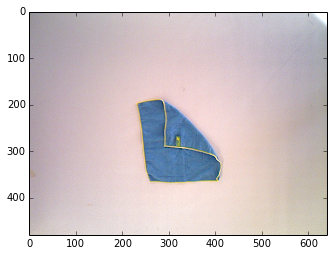

In [3]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

From this RGB image we will obtain the garment, using a HSV-based segmentation

In [4]:
def get_coloured_item(image):
    # Convert to HSV color space
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
 
    # Threshold value and saturation (using Otsu for threshold selection)
    blur_s = cv2.GaussianBlur(image_hsv[:, :, 1],(5,5),0)
    ret, mask_s = cv2.threshold(blur_s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    blur_v = cv2.GaussianBlur(image_hsv[:, :, 2],(5,5),0) 
    ret, mask_v = cv2.threshold(blur_v, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mask = cv2.bitwise_and(mask_s, mask_v)

    # Filter result using morphological operations (closing)
    kernel = np.ones((5,5),np.uint8)    
    filtered_mask_close = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)
    filtered_mask_open = cv2.morphologyEx(filtered_mask_close, cv2.MORPH_OPEN, kernel, iterations=8)

    return filtered_mask_open

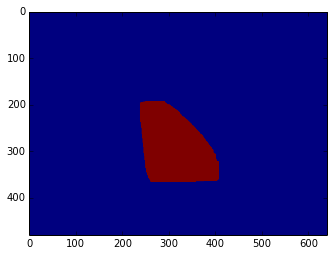

In [5]:
mask = get_coloured_item(image)
plt.imshow(mask)

From the garment mask, a simplified contour is extracted:

In [6]:
def get_garment_contour(mask):
    # Get clothes contour:
    clothes_contours, dummy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    clothes_contour = clothes_contours[0]
   
   # Size filtering:
    maxArea = cv2.contourArea(clothes_contour)
    for contour in clothes_contours[1:]:
        currentArea = cv2.contourArea(contour)
        if currentArea > maxArea:
            maxArea = currentArea
            clothes_contour = contour

    # Simplify contour:
    perimeter = cv2.arcLength(clothes_contour, True)
    approx = cv2.approxPolyDP(clothes_contour, 0.010 * perimeter, True)
    return approx

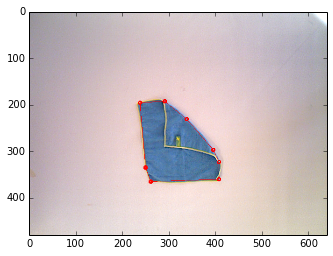

In [7]:
approx = get_garment_contour(mask)

# Print clothes contour
contour_show = image.copy()
cv2.drawContours(contour_show, [approx], -1, (0, 0,255))
for point in approx:
    cv2.circle(contour_show, tuple(point[0]), 3, (0, 0, 255), 2)
plt.imshow(cv2.cvtColor(contour_show, cv2.COLOR_BGR2RGB))

The obtained mask is applied then to the depth image, and the masked image is then normalized

In [8]:
def normalize_1Channel_image(image):
    scaled_depth_map = image.copy()
    min_value = masked_depth_image[np.unravel_index(np.where(masked_depth_image == 0, 1000,masked_depth_image).argmin(), masked_depth_image.shape)]
    max_value = masked_depth_image[np.unravel_index(np.where(masked_depth_image == 1000, 0,masked_depth_image).argmax(), masked_depth_image.shape)]
    range_value = max_value-min_value

    scaled_depth_map = np.where(scaled_depth_map != 1000, (scaled_depth_map - min_value) * (255/range_value), 255)
    scaled_depth_map = scaled_depth_map.astype(np.uint8)

    return scaled_depth_map

In [9]:
# Load depth image
depth_image = np.loadtxt(path_depth)
masked_depth_image = np.where(mask==255, depth_image.transpose(), 1000)

# Normalize depth map
scaled_depth_map = normalize_1Channel_image(masked_depth_image)

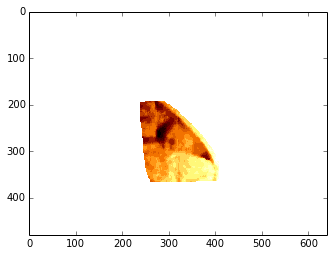

In [10]:
plt.imshow(scaled_depth_map, cmap=plt.cm.afmhot, interpolation='nearest')

### Watershed segmentation
Bla, bla, bla

In [11]:
from skimage.util import img_as_ubyte
from skimage.restoration import denoise_tv_chambolle
from skimage import exposure
from skimage.filters import rank
from skimage.morphology import watershed, disk
from scipy import ndimage as ndi 

image = img_as_ubyte(scaled_depth_map)
          
# denoise image
denoised = denoise_tv_chambolle(image, weight=0.05)
denoised_equalize= exposure.equalize_hist(denoised)  

# find continuous region (low gradient) --> markers
markers = rank.gradient(denoised_equalize, disk(25)) < 15 # 25,15  10,10

markers = ndi.label(markers)[0]

# local gradient
gradient = rank.gradient(denoised, disk(5))

# labels
labels = watershed(gradient, markers)
    

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


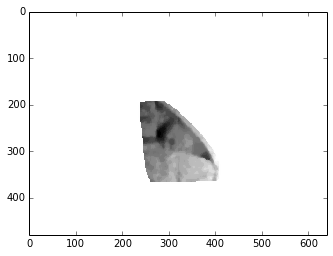

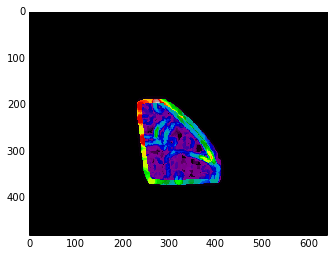

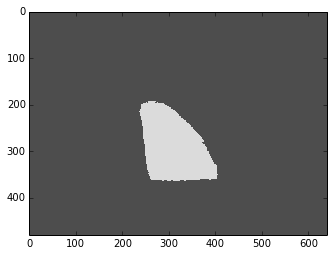

In [12]:
# display results  
plt.imshow(denoised, cmap=plt.cm.gray, interpolation='nearest')
plt.figure()
plt.imshow(gradient, cmap=plt.cm.spectral, interpolation='nearest')
plt.figure()
plt.imshow(labels, cmap=plt.cm.spectral, interpolation='nearest', alpha=.7) 
plt.show()

### Paths
The next step in our algorithm is to create a set of paths from the highest point in the garment to the midpoint of each contour segment. These paths are checked so that they are entirely located inside the garment, paths that go outside the garment contour are considered invalid.

First we average regions found with the watershed algorithm:

In [13]:
from skimage.measure import moments
from skimage.measure import label, regionprops
import operator

def get_average_regions(image, regions_image):
    """ Returns an image with the median value for each superpixel """
    labels = np.unique(regions_image)
    avg = np.zeros(regions_image.shape, np.uint8)

    for elem in labels:
        avg_value = np.median(np.extract(regions_image == elem,image))
        avg = np.where(regions_image == elem, int(avg_value), avg)
        
    return avg

def get_highest_point_with_superpixels(image):
    labels = np.unique(image)
    lowest_value = labels[np.unravel_index(labels.argmin(), labels.shape)]
    blobs = np.where(image<=lowest_value, 255, 0).astype(np.uint8)
    label_img = label(blobs)
    regions = regionprops(label_img)
    max_index, max_value = max(enumerate([props.area for props in regions]), key=operator.itemgetter(1))
    return regions[max_index].centroid

In [14]:
# calculate heights paths
img_src= scaled_depth_map    
avg = get_average_regions(img_src, labels)

# Get highest_points 
highest_points = [get_highest_point_with_superpixels(avg)[::-1]]

In [15]:
from textiles.ClothContour import ClothContour

# Get contour midpoints
cloth_contour = ClothContour(approx)
contour_segments, contour_midpoints = cloth_contour.segments, cloth_contour.midpoints

# Get paths to traverse:
valid_paths = cloth_contour.get_valid_paths(highest_points)

(Plot all paths vs valid paths)

### Obtaining profiles
Bla, bla, bla (again)

Slope: 2.064862 Length: 106.551330 Num samples: 106.000000
Slope: 2.064862 Length: 106.551330 Num samples: 106.000000
Slope: 0.374719 Length: 70.954022 Num samples: 70.000000
Slope: 0.374719 Length: 70.954022 Num samples: 70.000000
Slope: -1.084056 Length: 81.769219 Num samples: 81.000000
Slope: -1.084056 Length: 81.769219 Num samples: 81.000000
Slope: 3.060707 Length: 75.853564 Num samples: 75.000000
Slope: 3.060707 Length: 75.853564 Num samples: 75.000000
Slope: 0.529246 Length: 109.246738 Num samples: 109.000000
Slope: 0.529246 Length: 109.246738 Num samples: 109.000000
Slope: 0.221989 Length: 92.762004 Num samples: 92.000000
Slope: 0.221989 Length: 92.762004 Num samples: 92.000000
Slope: -0.466134 Length: 61.296892 Num samples: 61.000000
Slope: -0.466134 Length: 61.296892 Num samples: 61.000000
Slope: -21.896346 Length: 77.978453 Num samples: 77.000000
Slope: -21.896346 Length: 77.978453 Num samples: 77.000000


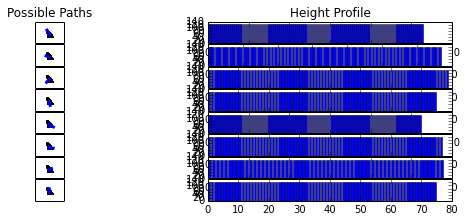

In [16]:
from textiles import Superpixels

profiles = []
all_line_data=[]

index_valid_path=0
for id, path in valid_paths:
    if path:
        index_valid_path+=1


fig, ax = plt.subplots(index_valid_path, 2)
fig.set_size_inches(8, 3, forward=True)
fig.subplots_adjust(0.06, 0.08, 0.97, 0.91, 0.15, 0.05)    
ax[0, 0].set_title('Possible Paths')
ax[0, 1].set_title('Height Profile')

index_valid_path=0
edges_to_profiles = {}
for id, path in valid_paths:
    if path:
        start = [p for p in path[0]]
        end = [p for p in path[1]]
        all_line_data.append([start, end])
        path_samples_avg = Superpixels.line_sampling(avg, start , end, 1)
        points = Superpixels.line_sampling_points(start, end, 1)

        without_white = [p for p in path_samples_avg if p != 255]
        profiles.append(without_white)  

        ax[index_valid_path, 0].set_xticks([]) 
        ax[index_valid_path, 0].set_yticks([])                         
        ax[index_valid_path, 0].imshow(avg, cmap=plt.cm.gray)
        ax[index_valid_path, 0].plot(points[0], points[1], lw=3)
        ax[index_valid_path, 1].bar(range(len(without_white)), without_white, lw=0.5)
        index_valid_path+=1
        edges_to_profiles[len(profiles)-1] = id
            
plt.show()

### Bumpiness calculation
Bumpiness is bla, bla, bla...

In [17]:
def calculate_bumpiness(profile, selection):
    var=0
    if selection==1:
        for i in range(1,len(profile)):            
            # cast to int because they were unit8 and failed to substract them
            var+=np.abs(int(profile[i])-int(profile[i-1]))
        return var
    else:
        return False

In [18]:
bumpiness = [calculate_bumpiness(elem,1) for elem in profiles]
print "bumpiness:", bumpiness

bumpiness: [0, 0, 0, 0, 0, 0, 0, 0]


We assume only one direction (for now)

In [19]:
selected_directions=[all_line_data[np.argmin(bumpiness)]]
print "Selected directions: ", selected_directions

Selected directions:  [[[309.44245393763077, 289.89725922523348], [263, 194]]]


(Here an averaging process might be performed, in case more than one directions were selected)

In [20]:
final_extremes = selected_directions[0]
print "Final Direction: ", final_extremes

Final Direction:  [[309.44245393763077, 289.89725922523348], [263, 194]]


### Segment extender
Bla, bla, bla extender bla, bla, bla

In [21]:
def segment_extender(x_start, y_start, x_end, y_end):
    
    start = [x_start, y_start]
    end = [x_end + (x_end-x_start), y_end + (y_end-y_start)]
    
    return [start, end]
    
    
def segment_extender_twosides(x_start, y_start, x_end, y_end):
    # 10 is just a number to assert long line cuts all image
    start = [x_start - 10*(x_end-x_start), y_start - 10*(y_end-y_start)]
    end = [x_end + 10*(x_end-x_start), y_end + 10*(y_end-y_start)]
    
    return [start, end]  

In [22]:
############ SEGMENT EXTENDER
# VARIABLE FOR FINAL POINTS (ONE IN SUPERPIXEL BORDER, THE OTHER IN IMAGE BORDER)    
extended_final_extremes = []    

# PROTOLINE
from scipy.spatial import distance
from textiles.intersect import perp, line_intersect

id_segment = edges_to_profiles[np.argmin(bumpiness)]

perp_vector = perp(np.array(contour_segments[id_segment][1])-np.array(contour_segments[id_segment][0]))
intersect_fold_axis = line_intersect(np.array(contour_segments[id_segment][0]),
                                     np.array(contour_segments[id_segment][1]),
                                     np.array(final_extremes[0]),
                                     np.array(final_extremes[0])+perp_vector)


# LONG LINE MASK 
# extending final_extremes a lot to be sure it cuts countour highest superpixel
long_line = segment_extender_twosides(final_extremes[0][0], final_extremes[0][1], 
                        intersect_fold_axis[0], intersect_fold_axis[1])

# create line mask to posterior logical intersection with countour
line_mask = np.zeros(mask.shape,np.uint8)
cv2.line(line_mask, (int(long_line[0][0]), int(long_line[0][1])), 
         (int(long_line[1][0]), int(long_line[1][1])), 255)    


# INITIAL POINT (INSIDE SUPERPIXEL)
# extracting countour highest superpixel
highest_region_mask = Superpixels.get_highest_superpixel(avg)
kernel = np.ones((5,5),np.uint8)
highest_region_mask_dilate = cv2.dilate(highest_region_mask,kernel,iterations = 1)
# only contour mask    
contour_superpixel_mask = highest_region_mask_dilate - highest_region_mask

# intersection long line and superpixel mask contour
intersection_img = np.logical_and( contour_superpixel_mask, line_mask )

# extracting countour centers (equivalent to extract intersection points)
(contours,_) =  cv2.findContours(img_as_ubyte(intersection_img),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)   
contour_intersect_points=[]
for i in range(len(contours)):
    contour_intersect_points.append(np.average(contours[i], axis=0))

# deciding which one is the initial initial point  
if np.fabs(distance.euclidean(final_extremes[0],contour_intersect_points[0][0])) < \
np.fabs(distance.euclidean(final_extremes[1],contour_intersect_points[0][0])):
    extended_final_extremes.append( (contour_intersect_points[0][0]).tolist() )
    print "option 1 for initial point"

else:
    extended_final_extremes.append( (contour_intersect_points[1][0]).tolist()  )
    print "option 2 for initial point"

# FINAL POINT (INSIDE IMAGE)
# reusing countour image and dilating
mask_dilate = cv2.dilate(mask,kernel,iterations = 1)

# only contour mask    
contour_mask = mask_dilate - mask    

# intersection long line and image mask contour
intersection_img_2 = np.logical_and( contour_mask, line_mask )

# extracting countour centers (equivalent to extract intersection points)    
(contours2,_) =  cv2.findContours(img_as_ubyte(intersection_img_2),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)   
contour_intersect_points2=[]

for i in range(len(contours2)):
    contour_intersect_points2.append(np.average(contours2[i], axis=0))

# deciding which one is the final point    
if np.fabs(distance.euclidean(final_extremes[0],contour_intersect_points2[0][0])) < \
np.fabs(distance.euclidean(final_extremes[1],contour_intersect_points2[0][0])):
    extended_final_extremes.append( (contour_intersect_points2[1][0]).tolist() )
    print "option 1 for final point"

else:
    extended_final_extremes.append( (contour_intersect_points2[0][0]).tolist()  )
    print "option 2 for final point"

# extending the segment out of the garment
traj = segment_extender(extended_final_extremes[0][0], extended_final_extremes[0][1], 
                        extended_final_extremes[1][0], extended_final_extremes[1][1])

option 1 for initial point
option 1 for final point


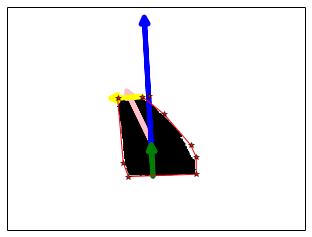

In [23]:
###### PLOTTING
# in case you need to sample a segment
#    final_line = Superpixels.line_sampling_points(final_extremes[0], final_extremes[1], 1)
fig, axis = plt.subplots(1, 1)
axis.imshow(avg, cmap=plt.cm.gray)
axis.set_xticks([]) 
axis.set_yticks([]) 

# in case of direction composed by two vectors
#    for i in range(len(selected_directions)):
#        axis.arrow(selected_directions[i][0][0], selected_directions[i][0][1], 
#                   selected_directions[i][1][0]-selected_directions[i][0][0], 
#                   selected_directions[i][1][1]-selected_directions[i][0][1], head_width=15, head_length=15, fc='blue', ec='blue')    

# final direction
axis.arrow(final_extremes[0][0], final_extremes[0][1], final_extremes[1][0]-final_extremes[0][0], 
           final_extremes[1][1]-final_extremes[0][1], head_width=15, head_length=15, 
            fc='pink', ec='pink', lw=5)

# final trajectory
axis.arrow(int(traj[0][0]), int(traj[0][1]), int(traj[1][0])-int(traj[0][0]), int(traj[1][1])-int(traj[0][1]), 
           head_width=15, head_length=15, fc='blue', ec='blue', lw=5)               

axis.arrow(int(traj[0][0]), int(traj[0][1]), int(perp_vector[0]), int(perp_vector[1]), 
           head_width=15, head_length=15, fc='green', ec='green', lw=5)  

axis.arrow(int(contour_segments[id_segment][0][0]), int(contour_segments[id_segment][0][1]), int(contour_segments[id_segment][1][0])-int(contour_segments[id_segment][0][0]), int(contour_segments[id_segment][1][1])-int(contour_segments[id_segment][0][1]), 
           head_width=15, head_length=15, fc='yellow', ec='yellow', lw=5) 

axis.plot(intersect_fold_axis[0],intersect_fold_axis[1], 'r*')
axis.plot([x[0][0] for x in approx], [x[0][1] for x in approx], 'r-*')